# Matched Filtering with PyCBC Inspiral

**Duncan A. Brown<sup>1,2</sup>**

**<sup>1</sup>Department of Physics, Syracuse University, Syracuse, NY 13244, USA**

**<sup>2</sup>DARK, Niels Bohr Institute, University of Copenhagen, Blegdamsvej 17, 2100 Copenhagen, Denmark**

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

## Introduction

This notebook demonstrates using the [``pycbc_inspiral``](https://raw.githubusercontent.com/ligo-cbc/pycbc/v1.7.5/bin/pycbc_inspiral) program to find the triggers from the LIGO Hanford and Livingston observatories corresponding to GW150914 event. This notebook uses the publically available [frame data from the LIGO Open Science Center (LOSC)](https://losc.ligo.org/events/GW150914/), input files from the [PyCBC Configuration GitHub repository](https://github.com/ligo-cbc/pycbc-config), and code from the [PyCBC GitHub repository.](https://github.com/ligo-cbc/pycbc)

This notebook can be run from the PyCBC Docker container, or a machine with PyCBC installed. Instructions for [downloading the docker container](http://ligo-cbc.github.io/pycbc/latest/html/docker.html) are available from the [PyCBC home page.](https://ligo-cbc.github.io/) To start a container with instance of Jupyter notebook, run the commands
```sh
docker pull pycbc/pycbc-el7:v1.7.5
docker run -p 8888:8888 --name pycbc_notebook -v -it pycbc/pycbc-el7:v1.7.5 /bin/bash -l
```
Once the container has started, this notebook can be downloaded with the command:
```sh
curl -L https://raw.githubusercontent.com/ligo-cbc/pycbc/master/examples/gw150914/PyCBCInspiral.ipynb > PyCBCInspiral.ipynb
```
The notebook server can be started inside the container with the command:
```sh
jupyter notebook --ip 0.0.0.0 --no-browser
```
You can then connect to the notebook at the URL printed by ``jupyter``.

There are several (arbitrary) choices that can be made when constructing a matched filter for binary mergers, including the overall normalization of the signal-to-noise ratio, the reference time in the waveform for which the search reports the arrival time, and a scale factor to keep numerical quantites close to unity to prevent round-off error. Understanding these choices is essential for interpreting the reported time, phase, and amplitude needed to construct the best-fit waveform for a signal.

``pycbc_inspiral`` used the FindChirp algorithm for matched filtering. For details of the choices made by the algorithm used here, see chapter 4 of [Duncan Brown's PhD thesis](https://arxiv.org/abs/0705.1514) and the [FindChirp paper in Phys Rev D.](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.85.122006)



## Setup notebook and download input data

The following code sets up plotting and imports modules that we will use later in the notebook.

In [1]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams['figure.figsize']=(14,5)

import numpy as np
import matplotlib.pyplot as plt

import pycbc.types
import pycbc.types.timeseries
import pycbc.fft
import pycbc.io.hdf
import pycbc.waveform

from pycbc import DYN_RANGE_FAC

### Download the input frame data from LOSC

The ``pycbc_inspiral`` code reads strain data from Frame format files. We download the calibrated frame data from the LIGO Open Science Center.

In [2]:
!if [ ! -f H-H1_LOSC_16_V2-1126257414-4096.gwf ] ; then curl https://losc.ligo.org/s/events/GW150914/H-H1_LOSC_16_V2-1126257414-4096.gwf > H-H1_LOSC_16_V2-1126257414-4096.gwf ; fi
!if [ ! -f L-L1_LOSC_16_V2-1126257414-4096.gwf ] ; then curl https://losc.ligo.org/s/events/GW150914/L-L1_LOSC_16_V2-1126257414-4096.gwf > L-L1_LOSC_16_V2-1126257414-4096.gwf ; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  493M  100  493M    0     0  5258k      0  0:01:36  0:01:36 --:--:-- 5221k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  474M  100  474M    0     0  4589k      0  0:01:45  0:01:45 --:--:-- 4617k0:49 5929k


### Download the veto files

These files are used to window out times when there are large delta function glitches in the input strain data that are identified by the Omicron burst search. This proceedure for identifying and removing these times from the search is described in the paper [GW150914: First results from the search for binary black hole coalescence with Advanced LIGO.](https://arxiv.org/abs/1602.03839)

In [3]:
!if [ ! -f H1-gating_C01_SNR300-1126051217-1129383017.txt.gz ] ; then curl -L https://raw.githubusercontent.com/ligo-cbc/pycbc-config/1e9aee13ebf85e916136afc4a9ae57f5b2d5bc64/O1/dq/H1-gating_C01_SNR300-1126051217-1129383017.txt.gz >  H1-gating_C01_SNR300-1126051217-1129383017.txt.gz ; fi
!if [ ! -f L1-gating_C01_SNR300-1126051217-1129383017.txt.gz ] ; then curl -L https://raw.githubusercontent.com/ligo-cbc/pycbc-config/1e9aee13ebf85e916136afc4a9ae57f5b2d5bc64/O1/dq/L1-gating_C01_SNR300-1126051217-1129383017.txt.gz >  L1-gating_C01_SNR300-1126051217-1129383017.txt.gz ; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2587  100  2587    0     0   2752      0 --:--:-- --:--:-- --:--:--  2752
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   876  100   876    0     0   1951      0 --:--:-- --:--:-- --:--:--  1955


### Download a template bank containing the best-matching template for GW150914

A bank of template parameters is needed as input to ``pycbc_inspiral``. The code will search over each template in the bank for a matching signal in the input strain data. The [full template bank](https://github.com/ligo-cbc/pycbc-config/blob/40a149012c6cc919b89342746dd9b31f894b20f5/O1/bank/README.md) used in the GW150914 search contains approximately 250,000 templates. Since we are only going to look at GW150914, we download a template bank containing only the template that best matches GW150915. This is the template indicated by a circle in Figure 1 of the paper [GW150914: First results from the search for binary black hole coalescence with Advanced LIGO.](https://arxiv.org/abs/1602.03839)

In [4]:
!if [ ! -f H1L1-GW150914_BANK-1126051217-3331800.xml ] ; then curl -L https://raw.githubusercontent.com/ligo-cbc/pycbc-config/master/O1/bank/H1L1-GW150914_BANK-1126051217-3331800.xml > H1L1-GW150914_BANK-1126051217-3331800.xml ;  fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5153  100  5153    0     0  12790      0 --:--:-- --:--:-- --:--:-- 12818


In order to use the template bank with the PyCBC trigger processing tools, we convert the XML format bank to HDF5.

In [5]:
!rm -f H1L1-GW150914_BANK-1126051217-3331800.hdf
!pycbc_coinc_bank2hdf --verbose --bank-file H1L1-GW150914_BANK-1126051217-3331800.xml --output H1L1-GW150914_BANK-1126051217-3331800.hdf


2017-08-07 10:54:13,964 Loading H1L1-GW150914_BANK-1126051217-3331800.xml
2017-08-07 10:54:14,020 Getting template hashes
2017-08-07 10:54:14,020 Writing to H1L1-GW150914_BANK-1126051217-3331800.hdf


## Setup pycbc_inspiral

The following cells are based on downloading ``pycbc_inspiral`` from the [v1.7.5](https://github.com/ligo-cbc/pycbc/releases/tag/v1.7.5) release of PyCBC. The production GW150914 search used the [v1.3.2](https://github.com/ligo-cbc/pycbc/releases/tag/v1.3.2) release of PyCBC. PyCBC's Travis CI build and test suite ensures that the results of the code have not changed since this v1.3.2 release, when the code is run with the same parameters used to report the detection of GW150914 in the discovery PRL.

### Code setup

``pycbc_inspiral`` is a stand-alone program that is designed to be run from the command line. To run it within an IPython notebook, we first download it with the ``%load`` command. We then modify the code to place the main program in the function
```python
def findchirp(subtract_waveform=None):
    # main pycbc_inspiral code goes here
    
    return [snr, norm, corr, idx, snrv], bank, segments, gwstrain
```
This allows us to run the code with the ``findchirp()`` function in this notebook and access the internal data structures of the code.

The argument ``subtract_waveform`` allows us to pass a ``pycbc.types.TimeSeries`` that is subtracted from the strain data prior to filtering. To do this, we add the lines
```python
    if subtract_waveform:
        logging.info('Removing waveform from input strain data')
        gwstrain -= subtract_waveform
```
after reading in the ``gwstrain`` using ``strain.from_cli()``.

Other than these modifications, the code is identical to the production filtering code.

In [6]:
# %load https://raw.githubusercontent.com/ligo-cbc/pycbc/v1.7.5/bin/pycbc_inspiral
#!/usr/bin/env python

# Copyright (C) 2014 Alex Nitz
#
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.

import sys
import logging, argparse, numpy, itertools
import pycbc
import pycbc.version
from pycbc import vetoes, psd, waveform, strain, scheme, fft, DYN_RANGE_FAC, events
from pycbc.vetoes.sgchisq import SingleDetSGChisq
from pycbc.filter import MatchedFilterControl, make_frequency_series, qtransform
from pycbc.types import TimeSeries, FrequencySeries, zeros, float32, complex64
import pycbc.fft.fftw, pycbc.version
import pycbc.opt
import pycbc.weave
import pycbc.inject
import time

last_progress_update = -1.0

def update_progress(p,u,n):
    """ updates a file 'progress.txt' with a value 0 .. 1.0 when enough (filtering) progress was made
    """
    global last_progress_update
    if p > last_progress_update + u:
        f = open(n,"w")
        if f:
            f.write("%.4f" % p)
            f.close()
        last_progress_update = p

def findchirp(subtract_waveform=None):
    global last_progress_update
    
    tstart = time.time()

    parser = argparse.ArgumentParser(usage='',
        description="Find single detector gravitational-wave triggers.")

    parser.add_argument('--version', action=pycbc.version.Version)
    parser.add_argument("-V", "--verbose", action="store_true",
                      help="print extra debugging information", default=False )
    parser.add_argument("--update-progress",
                      help="updates a file 'progress.txt' with a value 0 .. 1.0 when this amount of (filtering) progress was made",
                      type=float, default=0)
    parser.add_argument("--update-progress-file",
                      help="name of the file to write the amount of (filtering) progress to",
                      type=str, default="progress.txt")
    parser.add_argument("--output", type=str, help="FIXME: ADD")
    parser.add_argument("--bank-file", type=str, help="FIXME: ADD")
    parser.add_argument("--snr-threshold",
                      help="SNR threshold for trigger generation", type=float)
    parser.add_argument("--newsnr-threshold", type=float, metavar='THRESHOLD',
                        help="Cut triggers with NewSNR less than THRESHOLD")
    parser.add_argument("--low-frequency-cutoff", type=float,
                      help="The low frequency cutoff to use for filtering (Hz)")
    parser.add_argument("--enable-bank-start-frequency", action='store_true',
                      help="Read the starting frequency of template waveforms"
                           " from the template bank.")
    parser.add_argument("--max-template-length", type=float,
                      help="The maximum length of a template is seconds. The "
                           "starting frequency of the template is modified to "
                           "ensure the proper length")
    parser.add_argument("--enable-q-transform", action='store_true',
                      help="compute the q-transform for each segment of a "
                           "given analysis run. (default = False)")
    # add approximant arg
    pycbc.waveform.bank.add_approximant_arg(parser)
    parser.add_argument("--order", type=int,
                      help="The integer half-PN order at which to generate"
                           " the approximant. Default is -1 which indicates to use"
                           " approximant defined default.", default=-1,
                           choices = numpy.arange(-1, 9, 1))
    taper_choices = ["start","end","startend"]
    parser.add_argument("--taper-template", choices=taper_choices,
                        help="For time-domain approximants, taper the start and/or"
                        " end of the waveform before FFTing.")
    parser.add_argument("--cluster-method", choices=["template", "window"],
                        help="FIXME: ADD")
    parser.add_argument("--cluster-function", choices=["findchirp", "symmetric"],
                        help="How to cluster together triggers within a window. "
                        "'findchirp' uses a forward sliding window; 'symmetric' "
                        "will compare each window to the one before and after, keeping "
                        "only a local maximum.", default="findchirp")
    parser.add_argument("--cluster-window", type=float, default = -1,
                        help="Length of clustering window in seconds."
                        " Set to 0 to disable clustering.")
    parser.add_argument("--maximization-interval", type=float, default=0,
                        help="Maximize triggers over the template bank (ms)")
    parser.add_argument("--bank-veto-bank-file", type=str, help="FIXME: ADD")
    parser.add_argument("--chisq-snr-threshold", type=float,
                        help="Minimum SNR to calculate the power chisq")
    parser.add_argument("--chisq-bins", default=0, help=
                        "Number of frequency bins to use for power chisq. Specify"
                        " an integer for a constant number of bins, or a function "
                        "of template attributes.  Math functions are "
                        "allowed, ex. "
                        "'10./math.sqrt((params.mass1+params.mass2)/100.)'. "
                        "Non-integer values will be rounded down.")
    parser.add_argument("--chisq-threshold", type=float, default=0,
                        help="FIXME: ADD")
    parser.add_argument("--chisq-delta", type=float, default=0, help="FIXME: ADD")
    parser.add_argument("--autochi-number-points", type=int, default=0,
                        help="The number of points to use, in both directions if"
                             "doing a two-sided auto-chisq, to calculate the"
                             "auto-chisq statistic.")
    parser.add_argument("--autochi-stride", type=int, default=0,
                        help="The gap, in sample points, between the points at"
                             "which to calculate auto-chisq.")
    parser.add_argument("--autochi-two-phase", action="store_true",
                        default=False,
                        help="If given auto-chisq will be calculated by testing "
                             "against both phases of the SNR time-series. "
                             "If not given, only the phase matching the trigger "
                             "will be used.")
    parser.add_argument("--autochi-onesided", action='store', default=None,
                        choices=['left','right'],
                        help="Decide whether to calculate auto-chisq using"
                             "points on both sides of the trigger or only on one"
                             "side. If not given points on both sides will be"
                             "used. If given, with either 'left' or 'right',"
                             "only points on that side (right = forward in time,"
                             "left = back in time) will be used.")
    parser.add_argument("--autochi-reverse-template", action="store_true",
                        default=False,
                        help="If given, time-reverse the template before"
                             "calculating the auto-chisq statistic. This will"
                             "come at additional computational cost as the SNR"
                             "time-series will need recomputing for the time-"
                             "reversed template.")
    parser.add_argument("--autochi-max-valued", action="store_true",
                        default=False,
                        help="If given, store only the maximum value of the auto-"
                             "chisq over all points tested. A disadvantage of this "
                             "is that the mean value will not be known "
                             "analytically.")
    parser.add_argument("--autochi-max-valued-dof", action="store", metavar="INT",
                        type=int,
                        help="If using --autochi-max-valued this value denotes "
                             "the pre-calculated mean value that will be stored "
                             "as the auto-chisq degrees-of-freedom value.")
    parser.add_argument("--downsample-factor", type=int,
                        help="Factor that determines the interval between the "
                             "initial SNR sampling. If not set (or 1) no sparse sample "
                             "is created, and the standard full SNR is calculated.", default=1)
    parser.add_argument("--upsample-threshold", type=float,
                        help="The fraction of the SNR threshold to check the sparse SNR sample.")
    parser.add_argument("--upsample-method", choices=["pruned_fft"],
                        help="The method to find the SNR points between the sparse SNR sample.",
                        default='pruned_fft')
    parser.add_argument("--user-tag", type=str, metavar="TAG", help="""
                        This is used to identify FULL_DATA jobs for
                        compatibility with pipedown post-processing.
                        Option will be removed when no longer needed.""")
    parser.add_argument("--keep-loudest-interval", type=float,
                        help="Window in seconds to maximize triggers over bank")
    parser.add_argument("--keep-loudest-num", type=int,
                        help="Number of triggers to keep from each maximization interval")
    parser.add_argument("--gpu-callback-method", default='none')
    parser.add_argument("--use-compressed-waveforms", action="store_true", default=False,
                        help='Use compressed waveforms from the bank file.')
    parser.add_argument("--waveform-decompression-method", action='store', default=None,
                        help='Method to be used decompress waveforms from the bank file.')

    # Add options groups
    psd.insert_psd_option_group(parser)
    strain.insert_strain_option_group(parser)
    strain.StrainSegments.insert_segment_option_group(parser)
    scheme.insert_processing_option_group(parser)
    fft.insert_fft_option_group(parser)
    pycbc.opt.insert_optimization_option_group(parser)
    pycbc.weave.insert_weave_option_group(parser)
    pycbc.inject.insert_injfilterrejector_option_group(parser)
    SingleDetSGChisq.insert_option_group(parser)
    opt = parser.parse_args()

    # Check that the values returned for the options make sense
    psd.verify_psd_options(opt, parser)
    strain.verify_strain_options(opt, parser)
    strain.StrainSegments.verify_segment_options(opt, parser)
    scheme.verify_processing_options(opt, parser)
    fft.verify_fft_options(opt,parser)
    pycbc.opt.verify_optimization_options(opt, parser)
    pycbc.weave.verify_weave_options(opt, parser)

    pycbc.init_logging(opt.verbose)

    inj_filter_rejector = pycbc.inject.InjFilterRejector.from_cli(opt)
    ctx = scheme.from_cli(opt)
    gwstrain = strain.from_cli(opt, dyn_range_fac=DYN_RANGE_FAC,
                               inj_filter_rejector=inj_filter_rejector)
    
    # Add code to subtract a waveform from the input time series
    if subtract_waveform:
        logging.info('Removing waveform from input strain data')
        gwstrain -= subtract_waveform
    
    strain_segments = strain.StrainSegments.from_cli(opt, gwstrain)


    with ctx:
        fft.from_cli(opt)

        flow = opt.low_frequency_cutoff
        flen = strain_segments.freq_len
        tlen = strain_segments.time_len
        delta_f = strain_segments.delta_f


        logging.info("Making frequency-domain data segments")
        segments = strain_segments.fourier_segments()
        psd.associate_psds_to_segments(opt, segments, gwstrain, flen, delta_f,
                      flow, dyn_range_factor=DYN_RANGE_FAC, precision='single')

        # storage for values and types to be passed to event manager
        out_types = {
            'time_index'     : int,
            'snr'            : complex64,
            'chisq'          : float32,
            'chisq_dof'      : int,
            'bank_chisq'     : float32,
            'bank_chisq_dof' : int,
            'cont_chisq'     : float32,
                    }
        out_types.update(SingleDetSGChisq.returns)
        out_vals = {key: None for key in out_types}
        names = sorted(out_vals.keys())

        if len(strain_segments.segment_slices) == 0:
            logging.info("--filter-inj-only specified and no injections in analysis time")
            event_mgr = events.EventManager(
                  opt, names, [out_types[n] for n in names], psd=None,
                  gating_info=gwstrain.gating_info)
            event_mgr.finalize_template_events()
            event_mgr.write_events(opt.output)
            logging.info("Finished")
            sys.exit(0)

        if opt.enable_q_transform:
            logging.info("Performing q-transform on analysis segments")
            q_trans = qtransform.inspiral_qtransform_generator(segments)

        else:
            q_trans = {}

        # FIXME: Maybe we should use the PSD corresponding to each trigger
        event_mgr = events.EventManager(
                opt, names, [out_types[n] for n in names], psd=segments[0].psd,
                gating_info=gwstrain.gating_info, q_trans=q_trans)

        template_mem = zeros(tlen, dtype = complex64)
        cluster_window = int(opt.cluster_window * gwstrain.sample_rate)

        if opt.cluster_window == 0.0:
            use_cluster = False
        else:
            use_cluster = True

        if hasattr(ctx, "num_threads"):
                ncores = ctx.num_threads
        else:
                ncores = 1


        matched_filter = MatchedFilterControl(opt.low_frequency_cutoff, None,
                                       opt.snr_threshold, tlen, delta_f, complex64,
                                       segments, template_mem, use_cluster,
                                       downsample_factor=opt.downsample_factor,
                                       upsample_threshold=opt.upsample_threshold,
                                       upsample_method=opt.upsample_method,
                                       gpu_callback_method=opt.gpu_callback_method,
                                       cluster_function=opt.cluster_function)

        bank_chisq = vetoes.SingleDetBankVeto(opt.bank_veto_bank_file,
                                              flen, delta_f, flow, complex64,
                                              phase_order=opt.order,
                                              approximant=opt.approximant)

        power_chisq = vetoes.SingleDetPowerChisq(opt.chisq_bins, opt.chisq_snr_threshold)

        autochisq = vetoes.SingleDetAutoChisq(opt.autochi_stride,
                                     opt.autochi_number_points,
                                     onesided=opt.autochi_onesided,
                                     twophase=opt.autochi_two_phase,
                                     reverse_template=opt.autochi_reverse_template,
                                     take_maximum_value=opt.autochi_max_valued,
                                     maximal_value_dof=opt.autochi_max_valued_dof)

        logging.info("Overwhitening frequency-domain data segments")
        for seg in segments:
            seg /= seg.psd

        logging.info("Read in template bank")
        bank = waveform.FilterBank(opt.bank_file, flen, delta_f,
            low_frequency_cutoff=None if opt.enable_bank_start_frequency else flow,
            dtype=complex64, phase_order=opt.order,
            taper=opt.taper_template, approximant=opt.approximant,
            out=template_mem, max_template_length=opt.max_template_length,
            enable_compressed_waveforms=True if opt.use_compressed_waveforms else False,
            waveform_decompression_method=
            opt.waveform_decompression_method if opt.use_compressed_waveforms else None)

        sg_chisq = SingleDetSGChisq.from_cli(opt, bank, opt.chisq_bins)

        ntemplates = len(bank)
        nfilters = 0

        logging.info("Full template bank size: %s", ntemplates)
        bank.template_thinning(inj_filter_rejector)
        if not len(bank) == ntemplates:
            logging.info("Template bank size after thinning: %s", len(bank))

        tsetup = time.time() - tstart

        # Note: in the class-based approach used now, 'template' is not explicitly used
        # within the loop.  Rather, the iteration simply fills the memory specifed in
        # the 'template_mem' argument to MatchedFilterControl with the next template
        # from the bank.
        for t_num in xrange(len(bank)):
            tmplt_generated = False

            for s_num, stilde in enumerate(segments):
                # Filter check checks the 'inj_filter_rejector' options to
                # determine whether
                # to filter this template/segment if injections are present.
                if not inj_filter_rejector.template_segment_checker(
                        bank, t_num, stilde, opt.gps_start_time):
                    continue
                if not tmplt_generated:
                    template = bank[t_num]
                    event_mgr.new_template(tmplt=template.params,
                        sigmasq=template.sigmasq(segments[0].psd))
                    tmplt_generated = True

                if opt.cluster_method == "window":
                    cluster_window = int(opt.cluster_window * gwstrain.sample_rate)
                if opt.cluster_method == "template":
                    cluster_window = \
                        int(template.chirp_length * gwstrain.sample_rate)

                if opt.update_progress:
                    update_progress((t_num + (s_num / float(len(segments))) ) / len(bank),
                                    opt.update_progress, opt.update_progress_file)
                logging.info("Filtering template %d/%d segment %d/%d" %
                             (t_num + 1, len(bank), s_num + 1, len(segments)))

                nfilters = nfilters + 1
                snr, norm, corr, idx, snrv = \
                   matched_filter.matched_filter_and_cluster(s_num,
                                                             template.sigmasq(stilde.psd),
                                                             cluster_window,
                                                             epoch=stilde._epoch)

                if not len(idx):
                    continue

                out_vals['bank_chisq'], out_vals['bank_chisq_dof'] = \
                      bank_chisq.values(template, stilde.psd, stilde, snrv, norm,
                                        idx+stilde.analyze.start)

                out_vals['chisq'], out_vals['chisq_dof'] = \
                      power_chisq.values(corr, snrv, norm, stilde.psd,
                                         idx+stilde.analyze.start, template)

                out_vals['sg_chisq'] = sg_chisq.values(stilde, template, stilde.psd,
                                              snrv, norm,
                                              out_vals['chisq'],
                                              out_vals['chisq_dof'],
                                              idx+stilde.analyze.start)

                out_vals['cont_chisq'] = \
                      autochisq.values(snr, idx+stilde.analyze.start, template,
                                       stilde.psd, norm, stilde=stilde,
                                       low_frequency_cutoff=flow)

                idx += stilde.cumulative_index

                out_vals['time_index'] = idx
                out_vals['snr'] = snrv * norm

                event_mgr.add_template_events(names, [out_vals[n] for n in names])

            event_mgr.cluster_template_events("time_index", "snr", cluster_window)
            event_mgr.finalize_template_events()

    logging.info("Found %s triggers" % str(len(event_mgr.events)))

    if opt.chisq_threshold and opt.chisq_bins:
        logging.info("Removing triggers with poor chisq")
        event_mgr.chisq_threshold(opt.chisq_threshold, opt.chisq_bins,
                                  opt.chisq_delta)
        logging.info("%d remaining triggers" % len(event_mgr.events))

    if opt.newsnr_threshold and opt.chisq_bins:
        logging.info("Removing triggers with NewSNR below threshold")
        event_mgr.newsnr_threshold(opt.newsnr_threshold)
        logging.info("%d remaining triggers" % len(event_mgr.events))

    if opt.keep_loudest_interval:
        logging.info("Removing triggers that are not within the top %s loudest"
                     " of a %s second interval" % (opt.keep_loudest_num,
                                                   opt.keep_loudest_interval))
        event_mgr.keep_loudest_in_interval(opt.keep_loudest_interval * opt.sample_rate,
                                           opt.keep_loudest_num)
        logging.info("%d remaining triggers" % len(event_mgr.events))

    if opt.injection_window and hasattr(gwstrain, 'injections'):
        logging.info("Keeping triggers within %s seconds of injection" % opt.injection_window)
        event_mgr.keep_near_injection(opt.injection_window, gwstrain.injections)
        logging.info("%d remaining triggers" % len(event_mgr.events))

    if opt.maximization_interval:
        logging.info("Maximizing triggers over %s ms window" % opt.maximization_interval)
        window = int(opt.maximization_interval * gwstrain.sample_rate / 1000)
        event_mgr.maximize_over_bank("time_index", "snr", window)
        logging.info("%d remaining triggers" % len(event_mgr.events))

    tstop = time.time()
    run_time = tstop - tstart
    event_mgr.save_performance(ncores, nfilters, ntemplates, run_time, tsetup)

    logging.info("Writing out triggers")
    event_mgr.write_events(opt.output)

    if opt.fftw_output_float_wisdom_file:
        fft.fftw.export_single_wisdom_to_filename(opt.fftw_output_float_wisdom_file)

    if opt.fftw_output_double_wisdom_file:
        fft.fftw.export_double_wisdom_to_filename(opt.fftw_output_double_wisdom_file)

    logging.info("Finished")
    
    return [snr, norm, corr, idx, snrv], bank, segments, gwstrain

## Running the code

To run the code, we first set up the command line arguments for ``pycbc_inspiral`` before calling the ``findchirp()`` function. The command line arguments below are taken from the [production analysis](https://sugwg-jobs.phy.syr.edu/~dbrown/gw150914/gw150914-16day-c01-v1.3.2/7._open_box_result/) for the GW150914 result. We first run the code for the LIGO Hanford detector, and then for the LIGO Livingston detector.

The only difference between the command line arguments and the production arguments used in the discovery PRL are:

 1. The template bank used is contains only the best-matching template for GW150914.
 2. The ``--trig-start-time`` and ``--trig-end-time`` arguments that determine how much data will be searched for triggers are set to a 64 second interval centered the GPS time of GW150914 (1126259462) to avoid unncessary computation.
 3. We use the ``SEONBRv2`` time-domain template, rather than the ``SEOBNRv2_DoubleSpinROM`` frequency-domain template, as the using a time-domain waveform makes this notebook slightly simpler.
 4. We start the filtering at 25 Hz, rather than 30 Hz to generate a slightly longer template for better visualization.

### Set up command line arguments common to both detectors

The command line arguments below are common to running the code on both the Hanford and Livingston detector data.

In [7]:
argv = ['pycbc_inspiral', '--verbose']     
argv += ['--approximant=SEOBNRv2', '--order=-1', '--taper-template=start']
argv += ['--bank-file=H1L1-GW150914_BANK-1126051217-3331800.xml']
argv += ['--pad-data=8', '--sample-rate=4096', '--strain-high-pass=20']
argv += ['--segment-length=256', '--segment-start-pad=112', '--segment-end-pad=16']       
argv += ['--psd-estimation=median', '--psd-segment-stride=8', '--psd-segment-length=16', '--psd-inverse-length=16']
search_f_low = 25.0
argv += ['--low-frequency-cutoff={}'.format(search_f_low)] 
argv += ['--trig-start-time=1126259430', '--trig-end-time=1126259494']
argv += ["--chisq-bins=0.4*get_freq('fSEOBNRv2Peak',params.mass1,params.mass2,params.spin1z,params.spin2z)**(2./3.)"]
argv += ['--snr-threshold=5.5', '--newsnr-threshold=5']   
argv += ['--cluster-method=window', '--cluster-window=4', '--cluster-function=symmetric']
argv += ['--injection-window=4.5', '--filter-inj-only']        
argv += ['--processing-scheme=cpu']

### Run the code for the Hanford detector

We add the additional command line arguments that are specific to the Hanford detector and run the code.

In [8]:
argv_h1_data = ['--frame-files=H-H1_LOSC_16_V2-1126257414-4096.gwf', '--channel-name=H1:LOSC-STRAIN',
                '--gps-start-time=1126257636', '--gps-end-time=1126259684',
                '--gating-file=H1-gating_C01_SNR300-1126051217-1129383017.txt.gz'
               ]

In [9]:
argv_h1_out = ['--output=H1-INSPIRAL_FULL_DATA_JOB0-1126257771-1837.hdf', '--user-tag=FULL_DATA']

In [10]:
argv_h1 = argv + argv_h1_data + argv_h1_out
sys.argv = argv_h1

In [11]:
!rm -f H1-INSPIRAL_FULL_DATA_JOB0-1126257771-1837.hdf
h1_result = findchirp()

2017-08-07 10:54:17,062 Running with CPU support: 1 threads
2017-08-07 10:54:17,064 Reading Frames
2017-08-07 10:55:21,188 Highpass Filtering
2017-08-07 10:55:23,698 Converting to float32
2017-08-07 10:55:24,078 Gating glitches
2017-08-07 10:55:24,116 Resampling data
2017-08-07 10:55:37,221 Highpass Filtering
2017-08-07 10:55:38,023 Remove Padding
2017-08-07 10:55:38,027 Making frequency-domain data segments
2017-08-07 10:55:39,265 Overwhitening frequency-domain data segments
2017-08-07 10:55:39,273 Read in template bank
2017-08-07 10:55:39,533 Full template bank size: 1
2017-08-07 10:55:39,537 0: generating SEOBNRv2 from 25.0 Hz
2017-08-07 10:55:40,602 Filtering template 1/1 segment 1/1
2017-08-07 10:55:40,678 2 points above threshold
2017-08-07 10:55:40,681 ...Doing power chisq
2017-08-07 10:55:40,684 ...Calculating power chisq bins
2017-08-07 10:55:40,697 doing fast point chisq
2017-08-07 10:55:40,712 Found 2 triggers
2017-08-07 10:55:40,714 Removing triggers with NewSNR below thres

###  Run the code for the Livingston detector

We add the additional command line arguments that are specific to the Hanford detector and run the code.

In [12]:
argv_l1_data = ['--frame-files=L-L1_LOSC_16_V2-1126257414-4096.gwf', '--channel-name=L1:LOSC-STRAIN',
                '--gps-start-time=1126258108', '--gps-end-time=1126260156',
                '--gating-file=L1-gating_C01_SNR300-1126051217-1129383017.txt.gz'
               ]

In [13]:
argv_l1_out = ['--output=L1-INSPIRAL_FULL_DATA_JOB0-1126258302-1591.hdf', '--user-tag=FULL_DATA']

In [14]:
argv_l1 = argv + argv_l1_data + argv_l1_out
sys.argv = argv_l1

In [15]:
!rm -f L1-INSPIRAL_FULL_DATA_JOB0-1126258302-1591.hdf
l1_result = findchirp()

2017-08-07 10:55:41,798 Running with CPU support: 1 threads
2017-08-07 10:55:41,801 Reading Frames
2017-08-07 10:56:56,362 Highpass Filtering
2017-08-07 10:57:00,582 Converting to float32
2017-08-07 10:57:01,056 Gating glitches
2017-08-07 10:57:01,076 Resampling data
2017-08-07 10:57:14,771 Highpass Filtering
2017-08-07 10:57:15,680 Remove Padding
2017-08-07 10:57:15,684 Making frequency-domain data segments
2017-08-07 10:57:17,213 Overwhitening frequency-domain data segments
2017-08-07 10:57:17,222 Read in template bank
2017-08-07 10:57:17,618 Full template bank size: 1
2017-08-07 10:57:17,622 0: generating SEOBNRv2 from 25.0 Hz
2017-08-07 10:57:18,774 Filtering template 1/1 segment 1/1
2017-08-07 10:57:18,837 1 points above threshold
2017-08-07 10:57:18,839 ...Doing power chisq
2017-08-07 10:57:18,842 ...Calculating power chisq bins
2017-08-07 10:57:18,863 doing fast point chisq
2017-08-07 10:57:18,875 Found 1 triggers
2017-08-07 10:57:18,877 Removing triggers with NewSNR below thres

## Process the results

### Read triggers from the output files

The ``pycbc_inspiral`` code writes its output to the HDF5 files specified by the ``--output`` argument. We read in these files and find the triggers with the largest signal-to-noise ratio, as these triggers correspond to GW150914.

In [16]:
h1_triggers = pycbc.io.hdf.SingleDetTriggers(
    'H1-INSPIRAL_FULL_DATA_JOB0-1126257771-1837.hdf',
    'H1L1-GW150914_BANK-1126051217-3331800.hdf',
    None, None, None, 'H1'
)

l1_triggers = pycbc.io.hdf.SingleDetTriggers(
    'L1-INSPIRAL_FULL_DATA_JOB0-1126258302-1591.hdf',
    'H1L1-GW150914_BANK-1126051217-3331800.hdf',
    None, None, None, 'L1'
)

imax = np.argmax(h1_triggers.snr)
t_h1 = h1_triggers.end_time[imax]
t_idx_h1 = h1_result[0][3][np.argmax(np.abs(h1_result[0][4]))]
snr_h1 = h1_triggers.snr[imax]
sigmasq = h1_triggers.get_column('sigmasq')[0]
eff_distance_h1 = (sigmasq)**0.5 / snr_h1

imax = np.argmax(l1_triggers.snr)
t_l1 = l1_triggers.end_time[imax]
t_idx_l1 = l1_result[0][3][np.argmax(np.abs(l1_result[0][4]))]
snr_l1 = l1_triggers.snr[imax]
sigmasq = l1_triggers.get_column('sigmasq')[0]
eff_distance_l1 = (sigmasq)**0.5 / snr_l1

2017-08-07 10:57:19,006 Loading triggers
2017-08-07 10:57:19,090 Loading bank
2017-08-07 10:57:19,129 Loading triggers
2017-08-07 10:57:19,135 Loading bank


### Print the parameters of the GW150914 triggers

We print the arrival time, signal-to-noise ratio, and time delay for the H1 and L1 triggers. We also print the effective distance measured by the search code, as this is needed to scale the *amplitude* of the best-fit template.

``pycbc_inspiral`` records the sample index of the trigger, relative to the start of the strain time series that is read in. We save this arrival time offset as it will be used later to set the *arrival time* of the best-fit template.

In [17]:
print "H1 Time of event is {} with signal-to-noise ratio {}".format(t_h1, snr_h1)
print "L1 Time of event is {} with signal-to-noise ratio {}".format(t_l1, snr_l1)
print "HL arrival time difference = {} ms".format(t_h1-t_l1)
print "H1 Effective distance = {} Mpc, L1 effective distance = {} Mpc".format(eff_distance_h1, eff_distance_l1)
print "H1 arrival time offset = {}, L1 arrival time offset = {}".format(t_idx_h1,t_idx_l1)

H1 Time of event is 1126259462.42 with signal-to-noise ratio 19.8119182587
L1 Time of event is 1126259462.42 with signal-to-noise ratio 13.1280164719
HL arrival time difference = 0.007080078125 ms
H1 Effective distance = 956.212235338 Mpc, L1 effective distance = 1203.53064459 Mpc
H1 arrival time offset = 7481025, L1 arrival time offset = 5547684


### Plot the SNR time series for the two detectors

Now we plot the signal-to-noise ratio time series for each detector. The filtering function used by ``pycbc_inspiral`` generates the complex signal-to-noise ratio time series. In our code, this is returned in the array `` h1_result[0][0].data``. The complex signal-to-noise ratio is scaled by a normalization factor stored in ``h1_result[0][1]``. We plot the absolute value of the complex signal-to-noise, relative to GPS time 1126259462. For comparison, we draw vertical lines at the time of the GW150914 trigger. It can be seen that the signal-to-noise ratio time series peaks at the time of the trigger, as expected. We also store the array index of this peak, as we will use this to compute the phase of the best-fit template.

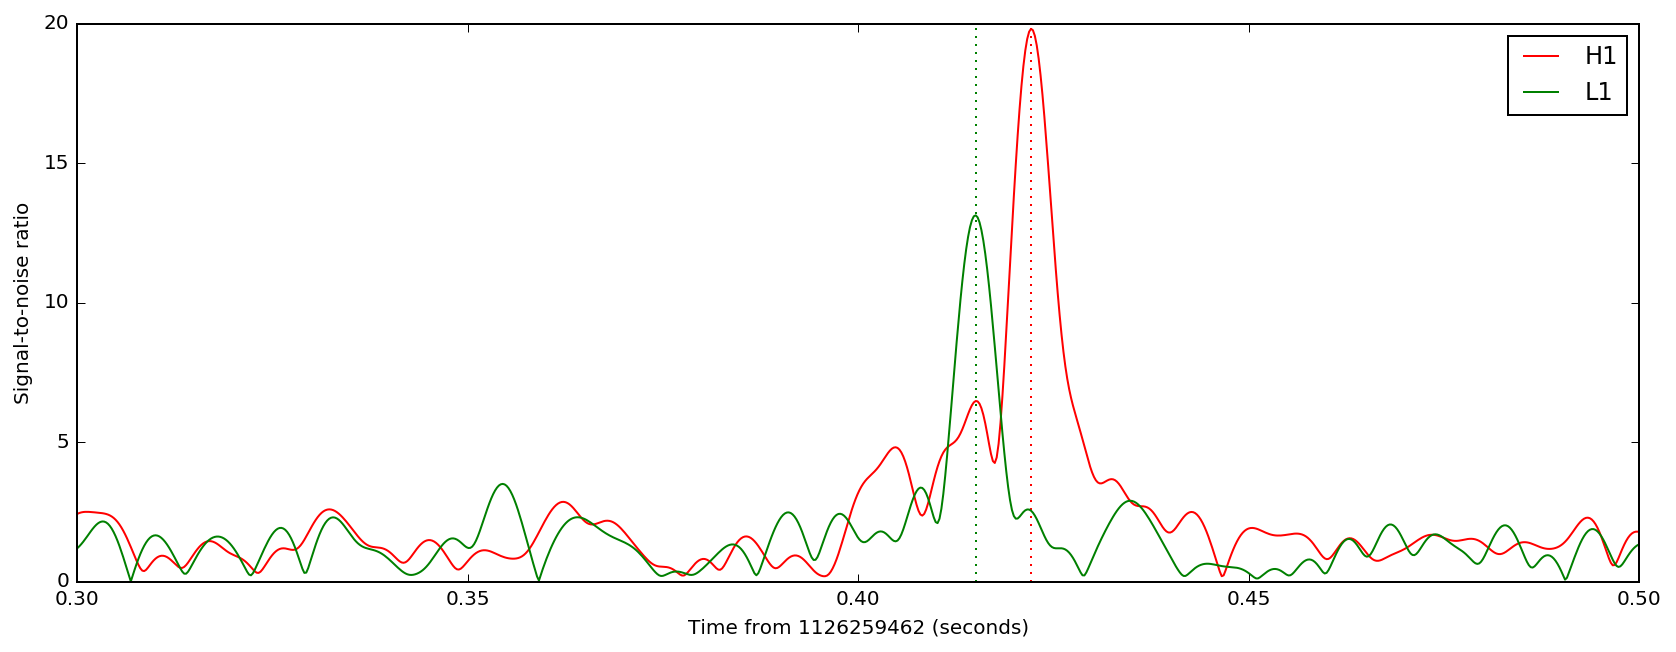

In [18]:
h1_complex_snr = h1_result[0][0].data*h1_result[0][1]
h1_snr_data = np.abs(h1_complex_snr)
h1_snr_t = h1_result[0][0].sample_times - 1126259462
h1_imax = np.argmax(h1_snr_data)

l1_complex_snr = l1_result[0][0].data*l1_result[0][1]
l1_snr_data = np.abs(l1_complex_snr)
l1_snr_t = l1_result[0][0].sample_times - 1126259462
l1_imax = np.argmax(l1_snr_data)

plt.plot(h1_snr_t,h1_snr_data,color='r',label="H1")
plt.axvline(t_h1-1126259462,color='r',linestyle=':')

plt.plot(l1_snr_t,l1_snr_data,color='g',label="L1")
plt.axvline(t_l1-1126259462,color='g',linestyle=':')

plt.legend(loc='best')
plt.xlim([0.3,0.5])
plt.ylim([0,20])
plt.xlabel("Time from 1126259462 (seconds)")
plt.ylabel("Signal-to-noise ratio")

### Compute the phase of the best fit template

We use the peak index and the complex signal-to-noise ratio to compute the *coalescence phase* of the best-fit template.

In [19]:
phase_h1 = np.arctan2(h1_complex_snr[h1_imax].imag,h1_complex_snr[h1_imax].real)
phase_l1 = np.arctan2(l1_complex_snr[l1_imax].imag,l1_complex_snr[l1_imax].real)

print "H1 Coalescence phase = {} radians, L1 Coalescence phase = {} radians".format(phase_h1,phase_l1)

H1 Coalescence phase = 2.00336503983 radians, L1 Coalescence phase = 0.765755176544 radians


## Plot the template used in the bank

For visual comparison, we plot the template used in the search compared to an ``SEOBNRv2`` waveform directly generated with the template parameters. ``pycbc_inspiral`` stores templates in the frequency domain, so we convert the template to the time domain for plotting with the command:
```python
template = h1_bank[0].to_timeseries()
```
The waveforms are computed for a signal at a distance of 1 Mpc. ``pycbc_inspiral`` applies an internal scaling of approximately 6e20 to scale these quanties up to order unity (the exact scaling is stored in the constant ``pycbc.DYN_RANGE_FAC``). We divide the amplitude of the template by ``DYN_RANGE_FAC`` so that it has the correct amplitude.

The FindChirp algorithm expects the peak time of the template to be at ``t = 0`` in the time domain so that the signal-to-noise ratio time series is time-stamped reference to the peak (coalescence) time of the waveform. Since the FFT is periodic, this means that the signal prior to the merger is at the *end* of the time-domain template and the merger-ringdown waveform is at the *start* of the time-domain template. We use NumPy's ``roll`` function to shift the sample points of the template so that it is contiguous and can be plotted against the result of calling ``pycbc.waveform.get_td_waveform()`` to generate the SEOBNRv2 waveform.

Notice that the only difference between the template waveform and the reference SEOBNRv2 waveform is that the search template is windowed at the start to prevent Gibbs ringing when it is transformed into the frequency domain.

In [20]:
h1_bank = h1_result[1]
l1_bank = l1_result[1]

2017-08-07 10:57:49,754 0: generating SEOBNRv2 from 25.0 Hz


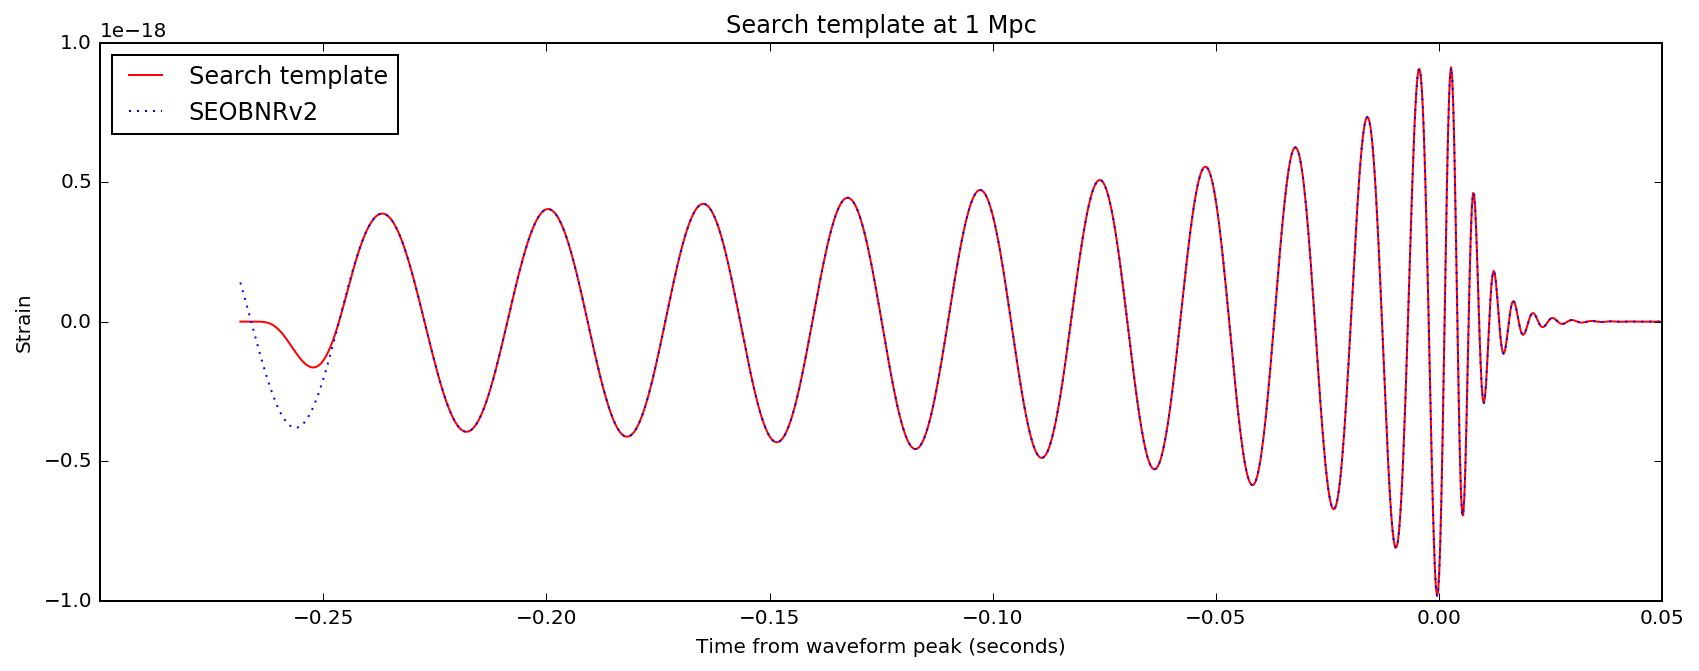

In [21]:
hp, hc = pycbc.waveform.get_td_waveform(
    approximant="SEOBNRv2",
    mass1=h1_bank.table['mass1'][0],
    mass2=h1_bank.table['mass2'][0],
    spin1z=h1_bank.table['spin1z'][0],
    spin2z=h1_bank.table['spin2z'][0],
    f_lower=search_f_low,
    delta_t=h1_bank.delta_t)

template = h1_bank[0].to_timeseries()

plt.plot(template.sample_times,
         np.roll(template,int(np.floor(-1.0*min(template.sample_times)/template.delta_t)))/DYN_RANGE_FAC,
         color='r',label='Search template')
plt.plot(hp.sample_times, hp,linestyle=':',label='SEOBNRv2')

plt.xlim([-0.3,0.05])
plt.title('Search template at 1 Mpc')
plt.legend(loc='best')
plt.ylabel('Strain'.format(DYN_RANGE_FAC))
plt.xlabel('Time from waveform peak (seconds)')

## Generate the best fit template

To generate the best-fit template, we must take the template above and apply the approriate time, phase, and amplitude shifts reported by the search code.

### Create storage for the template.

We generate an empty ``pycbc.types.TimeSeries`` for each template.

In [22]:
h1_best_fit_waveform = pycbc.types.TimeSeries(
    pycbc.types.Array(np.zeros(h1_bank.N),dtype=np.float32),
    delta_t=h1_bank.delta_t)

l1_best_fit_waveform = pycbc.types.TimeSeries(
    pycbc.types.Array(np.zeros(l1_bank.N),dtype=np.float32),
    delta_t=l1_bank.delta_t)

### Create the time-domain template

We apply the correct phase shift measured by the search code to the frequency-domain template and then inverse Fourier transform the search template into the time domain.

In [23]:
pycbc.fft.ifft(h1_bank[0]*np.exp(1j*phase_h1),h1_best_fit_waveform)
pycbc.fft.ifft(l1_bank[0]*np.exp(-1j*(phase_l1)),l1_best_fit_waveform)

2017-08-07 10:58:24,563 0: generating SEOBNRv2 from 25.0 Hz
2017-08-07 10:58:25,404 0: generating SEOBNRv2 from 25.0 Hz


### Create storage for template subtraction

We create an array containing zeros that is the same length and sample rate as the input strain time series. This is needed to subtract the best-fit template prior to filtering the data in ``pycbc_inspiral``.

In [24]:
h1_strain = h1_result[3]
l1_strain = l1_result[3]

h1_remove = pycbc.types.timeseries.TimeSeries(pycbc.types.Array(np.zeros(len(h1_strain))),
                                   delta_t=h1_strain.delta_t,
                                   dtype=np.float32, epoch=h1_strain.start_time)

l1_remove = pycbc.types.timeseries.TimeSeries(pycbc.types.Array(np.zeros(len(l1_strain))),
                                   delta_t=l1_strain.delta_t,
                                   dtype=np.float32, epoch=l1_strain.start_time)

### Place the template in the time series

Using the measured arrival index and amplitude scaling, we place the template at the correct location in the time series created in the previous cell.

When this cell is evaluated, the time series ``h1_remove`` and ``l1_remove`` will contain the correctly time, phase, and amplitude shifted waveform.

In [25]:
for i in range(len(h1_best_fit_waveform)/2):
    h1_remove.data[t_idx_h1+i] = h1_best_fit_waveform[i] / eff_distance_h1
    
for i in range(len(h1_best_fit_waveform)/2):
    h1_remove.data[t_idx_h1-(len(h1_best_fit_waveform)/2)+i] = h1_best_fit_waveform[i+len(h1_best_fit_waveform)/2] / eff_distance_h1

for i in range(len(l1_best_fit_waveform)/2):
    l1_remove.data[t_idx_l1+i] = l1_best_fit_waveform[i] / eff_distance_l1
    
for i in range(len(l1_best_fit_waveform)/2):
    l1_remove.data[t_idx_l1-(len(l1_best_fit_waveform)/2)+i] = l1_best_fit_waveform[i+len(l1_best_fit_waveform)/2] / eff_distance_l1

## Compare the best-fit waveform to the NR data

We now compare the best-fit template to the raw numerical relavity data shown in Figure 2 of the PRL, and the filtered NR waveform shown Figure 1 of the PRL.

### Load NR data from Figure 1

The LOSC NR data is scalled by a factor of 1e21. We undo this scaling when we plot the data for comparison to the best-fit waveform.

In [26]:
!if [ ! -f fig2-unfiltered-waveform-H.txt ] ; then curl -L "https://losc.ligo.org/s/events/GW150914/P150914/fig2-unfiltered-waveform-H.txt" > fig2-unfiltered-waveform-H.txt ; fi
!if [ ! -f fig2-unfiltered-waveform-L.txt ] ; then curl -L "https://losc.ligo.org/s/events/GW150914/P150914/fig2-unfiltered-waveform-L.txt" > fig2-unfiltered-waveform-L.txt ; fi
!if [ ! -f fig1-waveform-H.txt ] ; then curl -L "https://losc.ligo.org/s/events/GW150914/P150914/fig1-waveform-H.txt" > fig1-waveform-H.txt ; fi
!if [ ! -f fig1-waveform-L.txt ] ; then curl -L "https://losc.ligo.org/s/events/GW150914/P150914/fig1-waveform-L.txt" > fig1-waveform-L.txt ; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  169k  100  169k    0     0  90614      0  0:00:01  0:00:01 --:--:-- 90604
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  169k  100  169k    0     0   123k      0  0:00:01  0:00:01 --:--:--  123k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  169k  100  169k    0     0   118k      0  0:00:01  0:00:01 --:--:--  118k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  169k  100  169k    0     0   122k      0  0:00:01  0:00:01 --:--:--  122k


In [27]:
nr_filt_data = np.loadtxt("fig1-waveform-H.txt")
dt=nr_filt_data[1,0]-nr_filt_data[0,0]
h1_nr_filt_hp = pycbc.types.TimeSeries(nr_filt_data[:,1],delta_t=dt,epoch=nr_filt_data[0,0])

nr_data = np.loadtxt("fig2-unfiltered-waveform-H.txt")
dt=nr_data[1,0]-nr_data[0,0]
h1_nr_hp = pycbc.types.TimeSeries(nr_data[:,1],delta_t=dt,epoch=nr_data[0,0])

nr_filt_data = np.loadtxt("fig1-waveform-L.txt")
dt=nr_filt_data[1,0]-nr_filt_data[0,0]
l1_nr_filt_hp = pycbc.types.TimeSeries(nr_filt_data[:,1],delta_t=dt,epoch=nr_filt_data[0,0])

nr_data = np.loadtxt("fig2-unfiltered-waveform-L.txt")
dt=nr_data[1,0]-nr_data[0,0]
l1_nr_hp = pycbc.types.TimeSeries(nr_data[:,1],delta_t=dt,epoch=nr_data[0,0])

### Trim the best fit waveform

For faster plotting, we trim the full ``h1_remove`` and ``l1_remove`` time series to an interval of 2 seconds before and 2 seconds after GPS time 1126259462.

In [28]:
h1_bf = h1_remove.time_slice(1126259462-2,1126259462+2)
l1_bf = l1_remove.time_slice(1126259462-2,1126259462+2)

h1_bf.save('H1BestFitTemplate.txt')
l1_bf.save('L1BestFitTemplate.txt')

### Compare the best-fit waveform to the Fig 1 data

We plot the best-fit waveform from the search and compare it to the data from Figure 1 of the PRL. The L1 raw NR waveform is shifted by 0.007 s and multiplied by -1, as described in the caption of Figure 1.

Notice that in both of these plots there is a phase shift between the *raw NR waveform* and the *filtered NR waveform*. This is beacuse the filters used in Figure 1 of the PRL are not phase preserving.

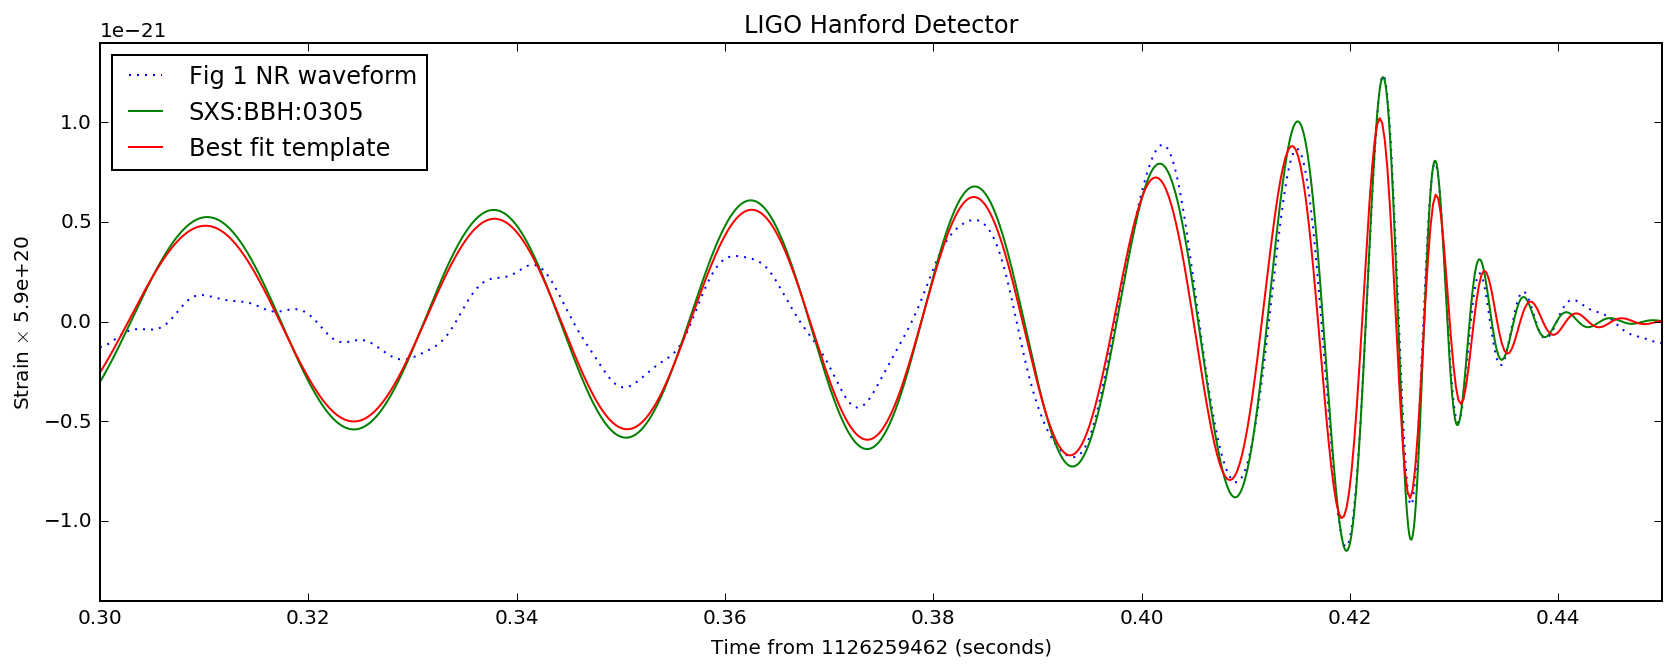

In [29]:
plt.plot(h1_nr_filt_hp.sample_times, h1_nr_filt_hp*1e-21,
         color='b', label='Fig 1 NR waveform',linestyle=':')
plt.plot(h1_nr_hp.sample_times, h1_nr_hp*1e-21 ,color='g', label='SXS:BBH:0305')
plt.plot(h1_bf.sample_times-1126259462, h1_bf/DYN_RANGE_FAC, color='r', label='Best fit template')

plt.xlim([0.3,0.45])
plt.ylim([-1.4e-21,1.4e-21])
plt.title('LIGO Hanford Detector')
plt.legend(loc='best')
plt.ylabel('Strain $\\times$ {0:.1e}'.format(DYN_RANGE_FAC))
plt.xlabel('Time from 1126259462 (seconds)')

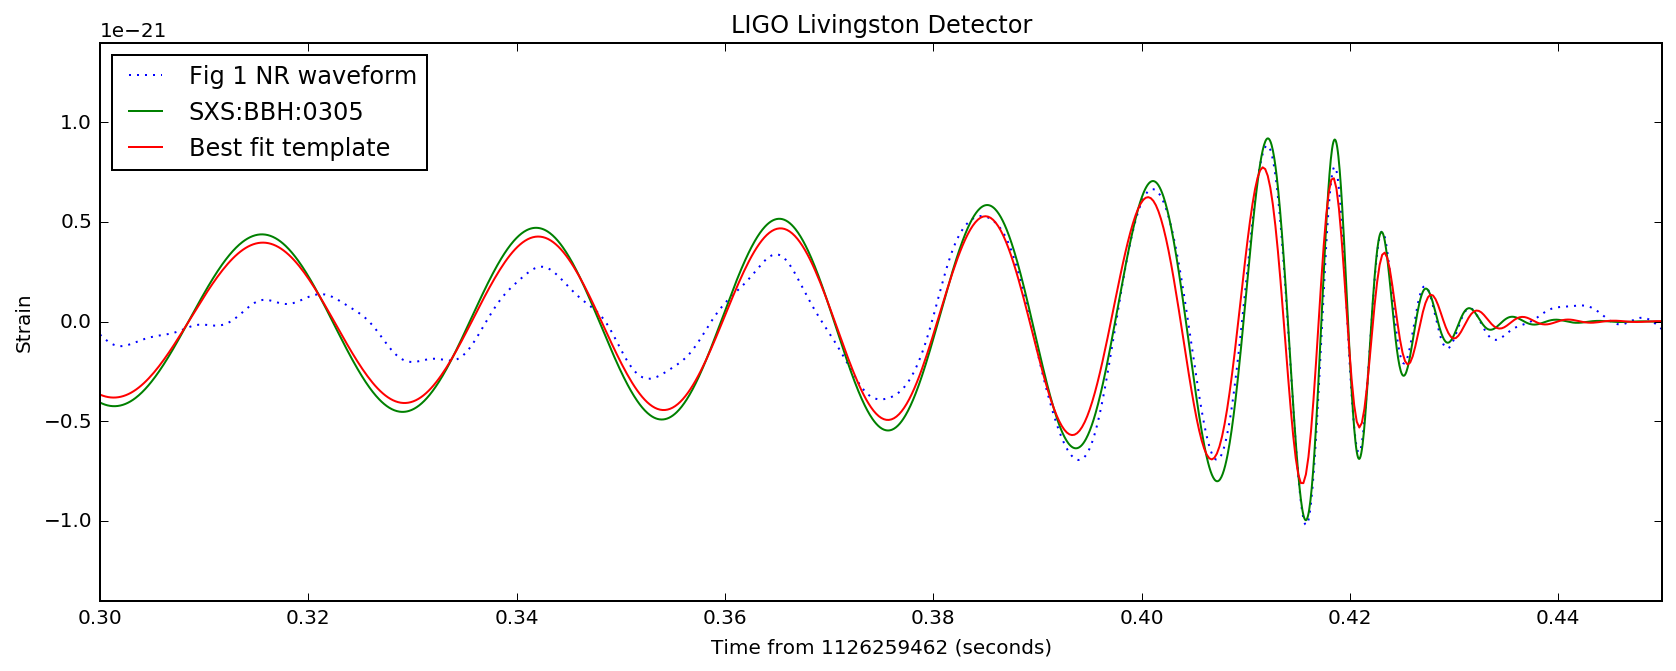

In [30]:
plt.plot(l1_nr_filt_hp.sample_times, l1_nr_filt_hp*1e-21,
         color='b', label='Fig 1 NR waveform',linestyle=':')
plt.plot(l1_nr_hp.sample_times-0.007, l1_nr_hp*-1e-21, color='g', label='SXS:BBH:0305')
plt.plot(l1_bf.sample_times-1126259462, l1_bf/DYN_RANGE_FAC, color='r', label='Best fit template')

plt.xlim([0.3,0.45])
plt.ylim([-1.4e-21,1.4e-21])
plt.title('LIGO Livingston Detector')
plt.legend(loc='best')
plt.ylabel('Strain')
plt.xlabel('Time from 1126259462 (seconds)')

## Filter the data with the best-fit waveform subtracted

We now re-run ``pycbc_inspiral`` but this time we pass the best-fit waveform to the ``findchip()`` function so that it is removed from the data prior to the matched filter.

Since we have removed the GW150914 signal, the search code should not find any triggers. In the case where no triggers are found ``pycbc_inspiral``'s filtering function does not return any data. To force the code to return the signal-to-noise ratio time series, we set the SNR and newSNR thresholds to unity before running it.

### Hanford detector

In [31]:
sys.argv = [a for a in argv_h1 if not (a.startswith('--snr-threshold') or a.startswith('--newsnr-threshold'))]
sys.argv += ['--snr-threshold=1', '--newsnr-threshold=1']

!rm -f H1-INSPIRAL_FULL_DATA_JOB0-1126257771-1837.hdf
h1_null_result = findchirp(h1_remove)

2017-08-07 10:59:20,404 Running with CPU support: 1 threads
2017-08-07 10:59:20,406 Reading Frames
2017-08-07 11:00:46,011 Highpass Filtering
2017-08-07 11:00:49,782 Converting to float32
2017-08-07 11:00:50,275 Gating glitches
2017-08-07 11:00:50,317 Resampling data
2017-08-07 11:01:00,448 Highpass Filtering
2017-08-07 11:01:01,057 Remove Padding
2017-08-07 11:01:01,058 Removing waveform from input strain data
2017-08-07 11:01:01,072 Making frequency-domain data segments
2017-08-07 11:01:02,195 Overwhitening frequency-domain data segments
2017-08-07 11:01:02,206 Read in template bank
2017-08-07 11:01:02,611 Full template bank size: 1
2017-08-07 11:01:02,615 0: generating SEOBNRv2 from 25.0 Hz
2017-08-07 11:01:03,830 Filtering template 1/1 segment 1/1
2017-08-07 11:01:03,909 5 points above threshold
2017-08-07 11:01:03,911 ...Doing power chisq
2017-08-07 11:01:03,918 ...Calculating power chisq bins
2017-08-07 11:01:03,947 doing fast point chisq
2017-08-07 11:01:03,976 Found 5 triggers


### Livingston detector

In [32]:
sys.argv = [a for a in argv_l1 if not (a.startswith('--snr-threshold') or a.startswith('--newsnr-threshold'))]
sys.argv += ['--snr-threshold=1', '--newsnr-threshold=1']

!rm -f L1-INSPIRAL_FULL_DATA_JOB0-1126258302-1591.hdf
l1_null_result = findchirp(l1_remove)

2017-08-07 11:01:04,655 Running with CPU support: 1 threads
2017-08-07 11:01:04,658 Reading Frames
2017-08-07 11:02:22,776 Highpass Filtering
2017-08-07 11:02:26,577 Converting to float32
2017-08-07 11:02:27,056 Gating glitches
2017-08-07 11:02:27,072 Resampling data
2017-08-07 11:02:39,445 Highpass Filtering
2017-08-07 11:02:40,340 Remove Padding
2017-08-07 11:02:40,342 Removing waveform from input strain data
2017-08-07 11:02:40,366 Making frequency-domain data segments
2017-08-07 11:02:41,569 Overwhitening frequency-domain data segments
2017-08-07 11:02:41,580 Read in template bank
2017-08-07 11:02:41,870 Full template bank size: 1
2017-08-07 11:02:41,879 0: generating SEOBNRv2 from 25.0 Hz
2017-08-07 11:02:42,704 Filtering template 1/1 segment 1/1
2017-08-07 11:02:42,763 6 points above threshold
2017-08-07 11:02:42,765 ...Doing power chisq
2017-08-07 11:02:42,768 ...Calculating power chisq bins
2017-08-07 11:02:42,780 doing fast point chisq
2017-08-07 11:02:42,797 Found 6 triggers


## Plot the signal-to-noise ratio time series

Now we plot the signal-to-noise ratio time series returned by the search for each detector, with vertial lines indicating the trigger times of GW150914.

Notice that there is no trigger corresponding to GW150914 in the output and the values of the SNR at the time of the GW150914 are consistent with noise.

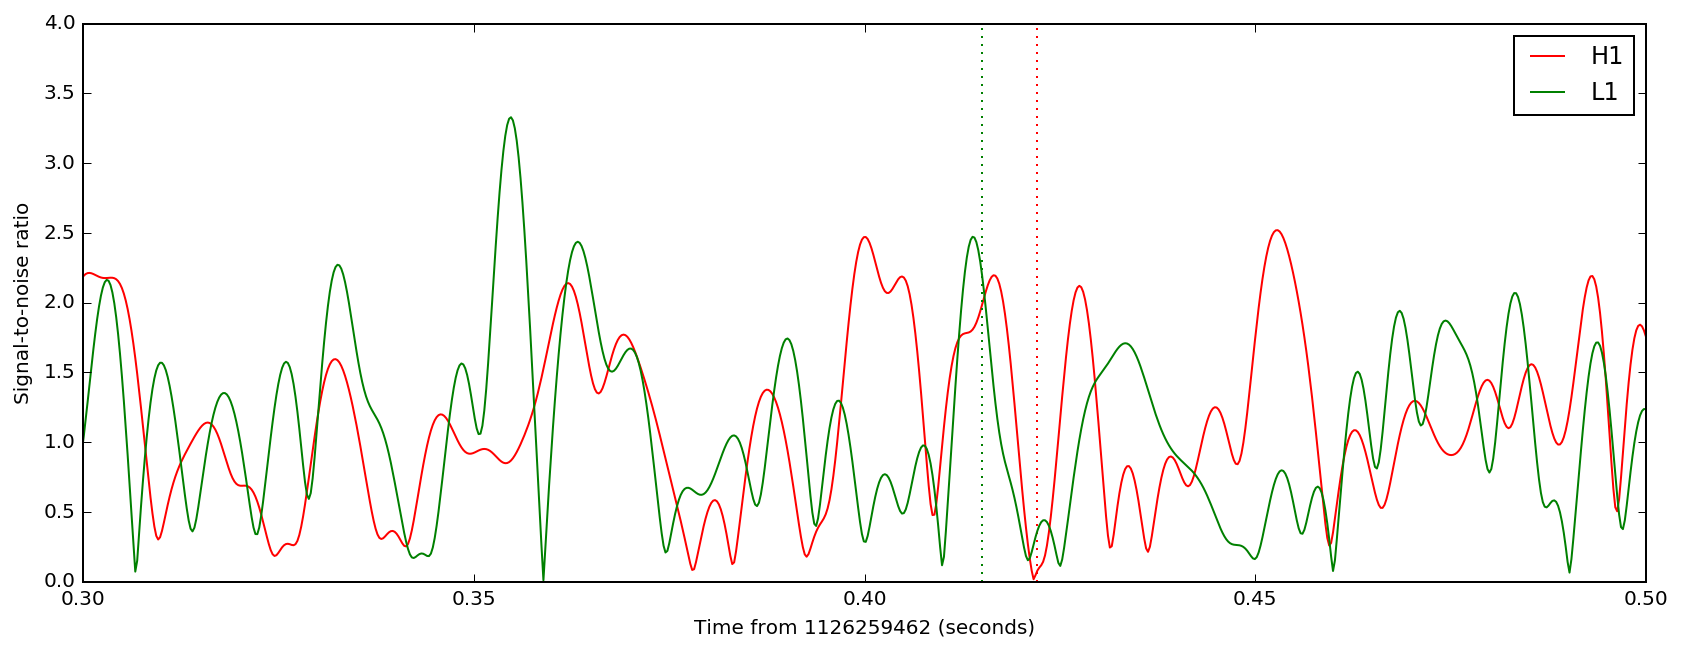

In [33]:
h1_complex_snr = h1_null_result[0][0].data*h1_null_result[0][1]
h1_snr_data = np.abs(h1_complex_snr)
h1_snr_t = h1_null_result[0][0].sample_times - 1126259462

l1_complex_snr = l1_null_result[0][0].data*l1_null_result[0][1]
l1_snr_data = np.abs(l1_complex_snr)
l1_snr_t = l1_null_result[0][0].sample_times - 1126259462

plt.plot(h1_snr_t,h1_snr_data,color='r',label="H1")
plt.axvline(t_h1-1126259462,color='r',linestyle=':')

plt.plot(l1_snr_t,l1_snr_data,color='g',label="L1")
plt.axvline(t_l1-1126259462,color='g',linestyle=':')

plt.legend(loc='best')
plt.xlim([0.3,0.5])
plt.ylim([0,4])
plt.xlabel("Time from 1126259462 (seconds)")
plt.ylabel("Signal-to-noise ratio")

## Plot the whitened strain data

The matched filter in ``pycbc_inspiral`` stores the [overwhitened strain data](https://github.com/ligo-cbc/pycbc/blob/v1.7.5/bin/pycbc_inspiral#L294). Data is overwhitened in the frequency domain by dividing by the time-truncated inverse power spectral density of the data, as described in the the [FindChirp algorithm.](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.85.122006) To plot the whitened strain, we multiply the frequency-domain overwhitened data by the square root of the power spectral density used to overwhiten it, then use PyCBC's ``to_timeseries()`` function to transform back to the time domain.

**Note:** this whitened strain is not used by any downstream product and it is not normally constructed by ``pycbc_inspiral``. It is just used here to plot whitened strain data for visualization of the results of this notebook.

In [34]:
whitened_strain_h1 = (h1_result[2][0]*(h1_result[2][0].psd**0.5)).to_timeseries()
whitened_strain_l1 = (l1_result[2][0]*(l1_result[2][0].psd**0.5)).to_timeseries()

whitened_null_strain_h1 = (h1_null_result[2][0]*(h1_null_result[2][0].psd**0.5)).to_timeseries()
whitened_null_strain_l1 = (l1_null_result[2][0]*(l1_null_result[2][0].psd**0.5)).to_timeseries()

### Plot the data used by the search

We first plot the data used by the search. We offset the L1 data by the measured time of arrival difference, and multiply the Livingston strain by a factor of -1 to account for the relative orientations of the Hanford and Livingston detetectors. The GW150914 signal is clearly visible in the data. More high-frequency noise is visible here than in Figure 1, as only low-pass filter applied is the anti-aliasing filtered used to downsample the input data. This has a higher frequency cutoff than the Butterworth filter used to make Figure 1. 

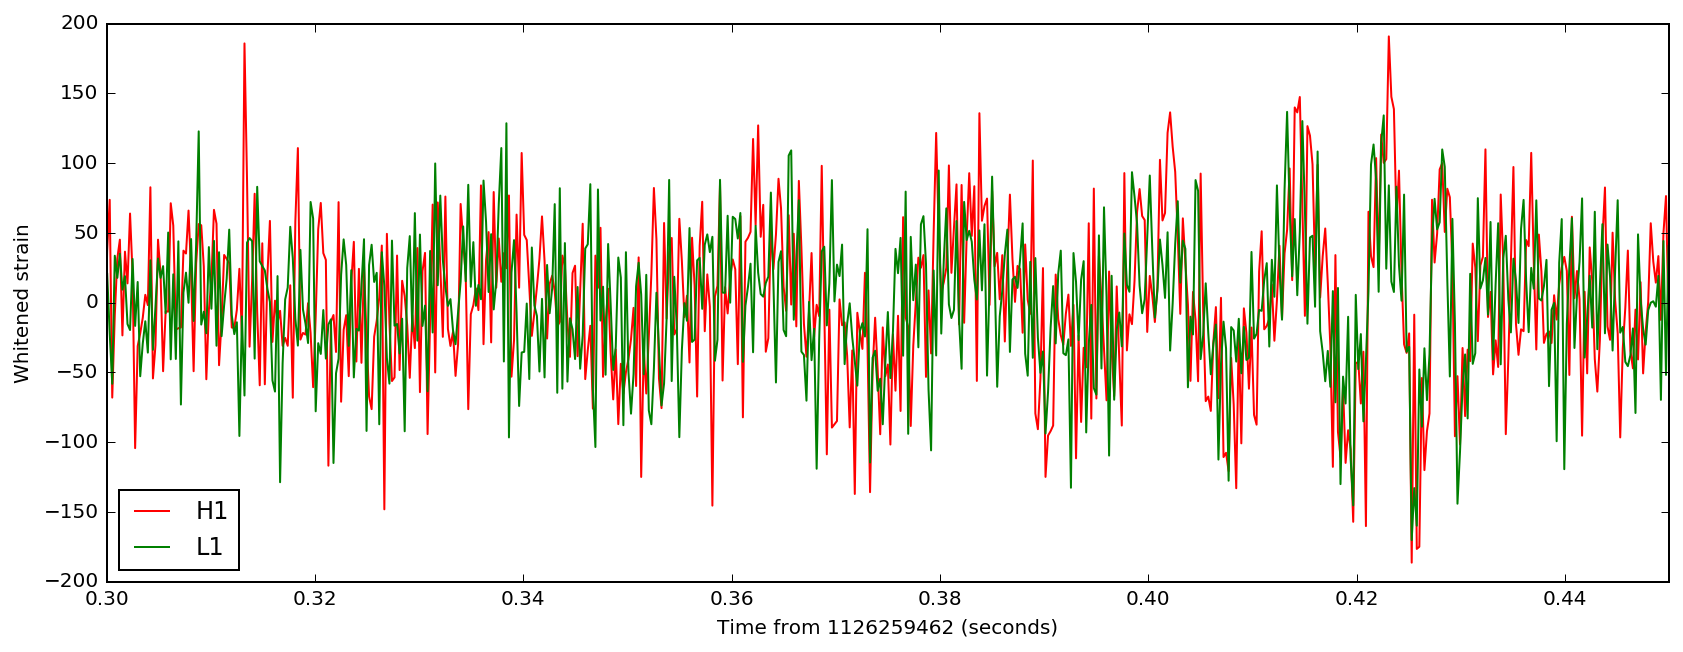

In [35]:
plt.plot(whitened_strain_h1.sample_times-1126259462,whitened_strain_h1,label='H1',color='r')
plt.plot(whitened_strain_l1.sample_times-1126259462+(t_h1-t_l1),-1.0*whitened_strain_l1,label='L1',color='g')

plt.xlim([0.3,0.45])
plt.ylim([-200,200])
plt.legend(loc='best')
plt.xlabel("Time from 1126259462 (seconds)")
plt.ylabel("Whitened strain")

### Plot the data with the waveform subtracted

We now plot the time-series data created by ``pycbc_inspiral`` after the best-fit waveform has been subtracted. The GW150914 signal is no longer visible by eye.

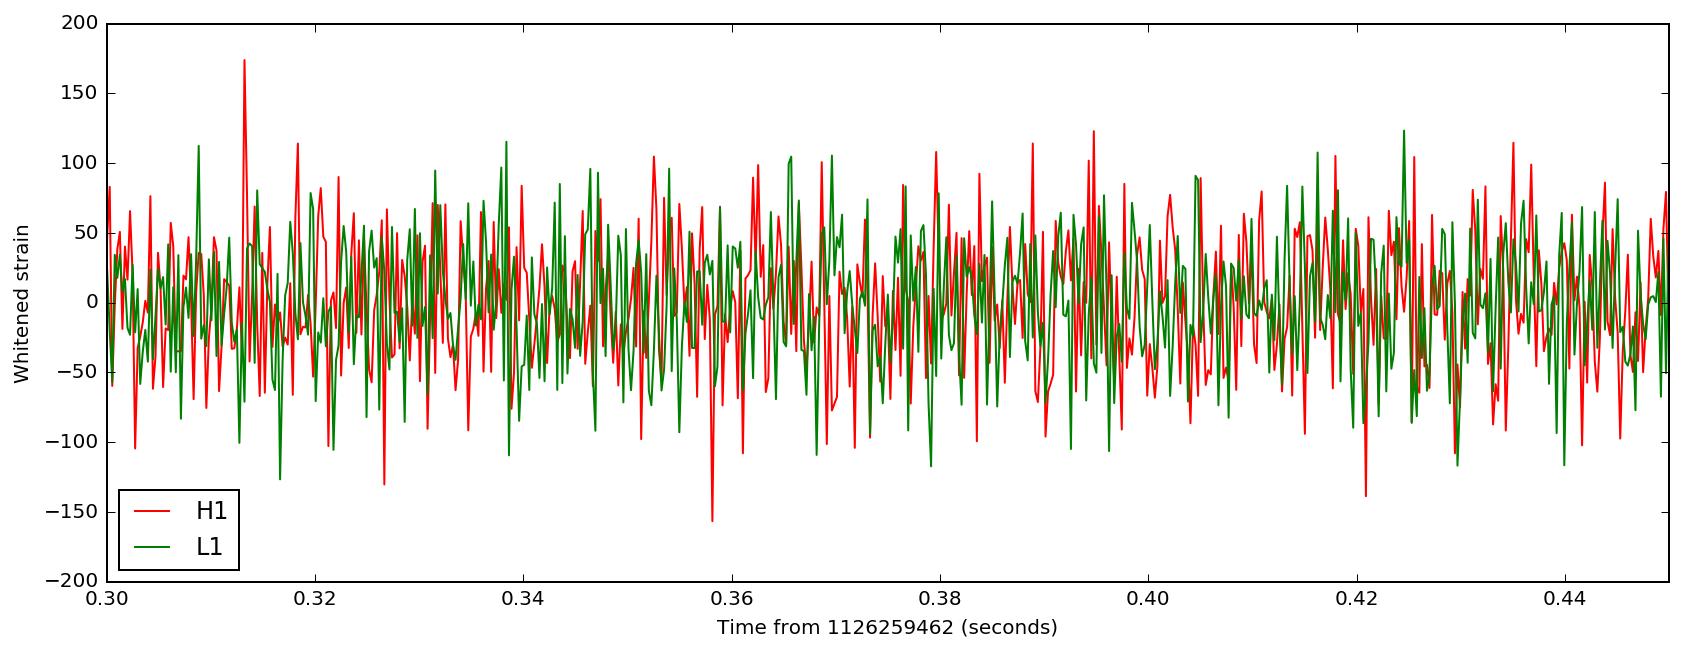

In [36]:
plt.plot(whitened_null_strain_h1.sample_times-1126259462,whitened_null_strain_h1,label='H1',color='r')
plt.plot(whitened_null_strain_l1.sample_times-1126259462+(t_h1-t_l1),-1.0*whitened_null_strain_l1,label='L1',color='g')

plt.xlim([0.3,0.45])
plt.ylim([-200,200])
plt.legend(loc='best')
plt.xlabel("Time from 1126259462 (seconds)")
plt.ylabel("Whitened strain")

## Correllations in the residual data

We now look numerically for correllations in the above strain data.

### Set up the correllation function

To compute the correllation of the residuals, we use the [code written by Creswell et al.](http://www.nbi.ku.dk/gravitational-waves/correlations.html) This code, when run on the data from the Figure 1 of the PRL, reproduces the green curve in the lower right plot in Figure 7 of Creswell et al.

Here we run the code on the strain data used by the filtering code.

In [37]:
def cross_correllation(h1_res_times, h1_res_strain, l1_res_times, l1_res_strain):
    
    fs = 1./(h1_res_times[1]-h1_res_times[0])

    t = 0.39
    w = 0.04

    min_indxt = np.where(abs(h1_res_times-t) == abs(h1_res_times-t).min())[0][0]
    max_indxt = np.where(abs(h1_res_times-(t+w)) == abs(h1_res_times-(t+w)).min())[0][0]

    deltatau = 0.01

    tauind_min = int(-deltatau*fs); tauind_max = int(+deltatau*fs)
    tauind = np.arange(tauind_min,tauind_max)
    tau = tauind/fs

    corr = []

    for i in tauind:
        corr.append(np.corrcoef(h1_res_strain[min_indxt+abs(tauind_min)+i:max_indxt-abs(tauind_max)+i],l1_res_strain[min_indxt+abs(tauind_min):max_indxt-abs(tauind_max)])[0][1])

    corr = np.array(corr)
    imax = np.argmax(abs(corr))

    plt.figure()
    plt.plot(tau * 1000.,corr,'k',label="t="+str(t)+", w="+str(w))
    plt.axvline(1000*tau[imax], color='k')
    plt.xlim(-10,10)
    plt.xlabel(r"$\tau$ [ms]")
    plt.ylabel(r"$C(t,\tau,w)$")
    plt.ylim(-.9,.7)
    plt.legend(loc='best')
    
    print('max |corr| = {:.2g} at tau = {:.3g} ms'.format(max(abs(corr)), 1000*tau[imax]))

### Correllation of the input strain

We first compute the cross correllation of the input strain data. A large peak can be seen at a time offset of 7.08 ms, corresponding to the GW150914 signal.

max |corr| = 0.67 at tau = 7.08 ms


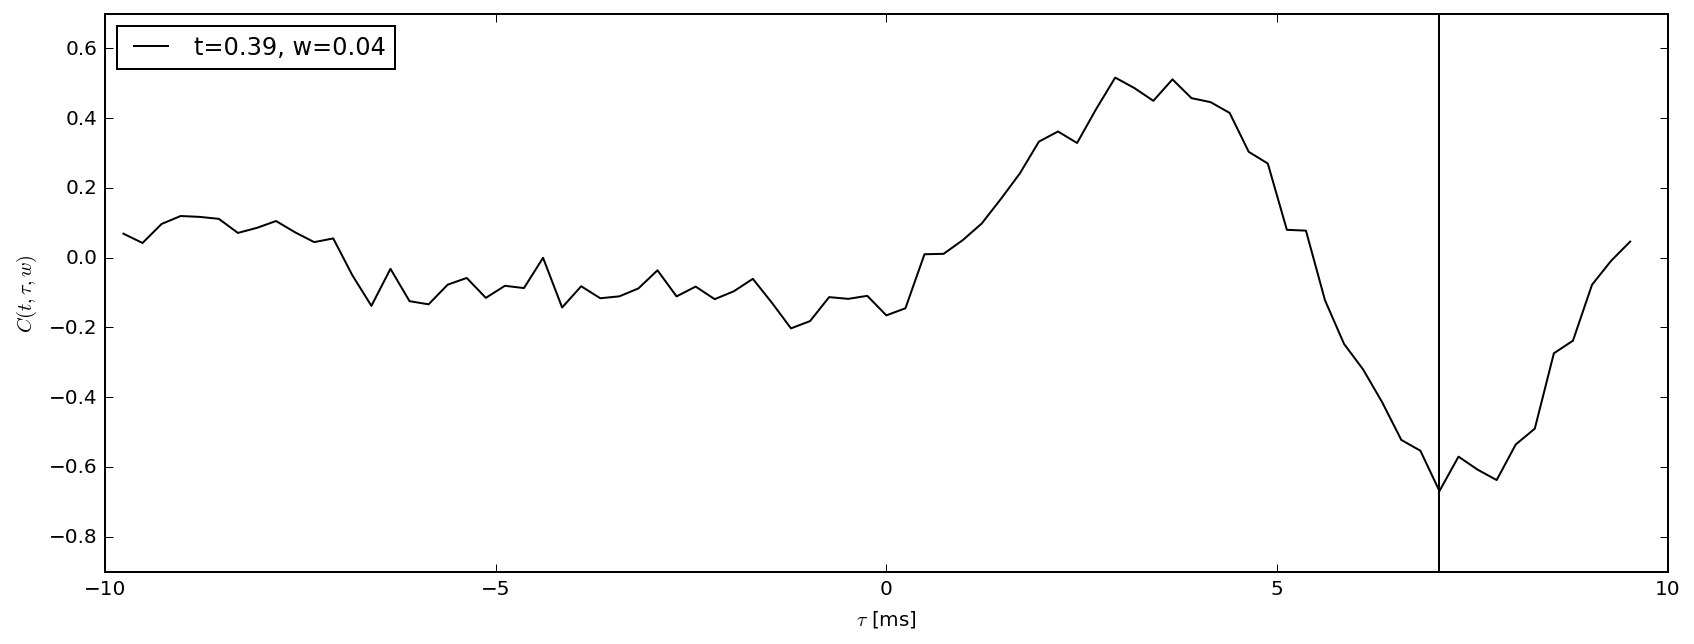

In [38]:
cross_correllation(whitened_strain_h1.sample_times.numpy()-1126259462,whitened_strain_h1.numpy(),
                     whitened_strain_l1.sample_times.numpy()-1126259462,whitened_strain_l1.numpy())

### Correllation of the waveform-subtracted strain

Now we compute the cross correllation of the strain data that has had the best-fit waveform subtracted. The peak at 7.08 ms is no longer present and the maximum value of the correllation is now 0.26.

max |corr| = 0.26 at tau = -4.39 ms


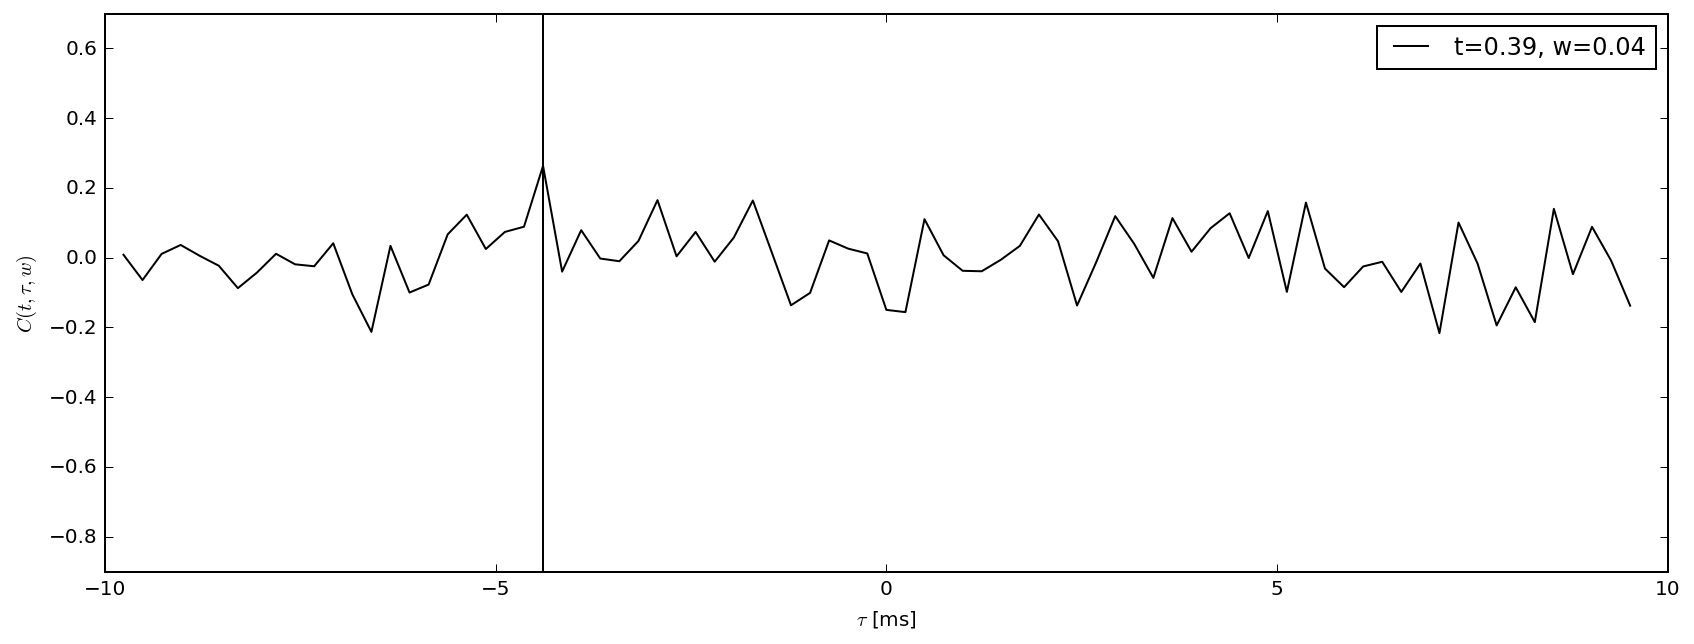

In [39]:
cross_correllation(whitened_null_strain_h1.sample_times.numpy()-1126259462,whitened_null_strain_h1.numpy(),
                     whitened_null_strain_l1.sample_times.numpy()-1126259462,whitened_null_strain_l1.numpy())

## Acknlowgements

DAB thanks 
Jeandrew Brink,
Jolien Creighton,
Will Farr, 
Ben Farr, 
Jon Gair, 
Ian Harry,
Daniel Holz, 
Andrew Jackson,
Joey Key,
Hao Liu,
Andrew Lundgren,
Jessica McIver, 
Pavel Naselsky, and
Alexander Nitz
for helpful discussions.
This work is supported by National Science Foundation award PHY-1707954.
DAB thanks the Niels Bohr Institute for its hospitality
while part of this work was completed, 
the Kavli Foundation and the DNRF for supporting the 2017 Kavli Summer Program.  

## Appendix: Version information

In [40]:
sys.argv = ['pycbc_inspiral', '--version']
try:
    findchirp()
except SystemExit:
    pass

--- PyCBC Version --------------------------
Branch: None
Tag: v1.7.5
Id: c52b16863162a73023f6d3f094e89555938e16d8
Builder: Unknown User <>
Build date: 2017-07-13 17:56:16 +0000
Repository status is CLEAN: All modifications committed

Imported from: /home/pycbc/pycbc-software/lib/python2.7/site-packages/PyCBC-1.7.5-py2.7.egg/pycbc/__init__.pyc

--- LAL Version ----------------------------
Branch: None
Tag: None
Id: 539c8700af92eb6dd00e0e91b9dbaf5bae51f004

Builder: Unknown User <>
Repository status: CLEAN: All modifications committed

Imported from: /home/pycbc/pycbc-software/opt/lalsuite/lib64/python2.7/site-packages/lal/__init__.pyc

Runtime libraries:
	linux-vdso.so.1 =>  (0x00007fff349f8000)
	liblalsupport.so.9 => /home/pycbc/pycbc-software/opt/lalsuite/lib/liblalsupport.so.9 (0x00007fc7cafe6000)
	liblal.so.13 => /home/pycbc/pycbc-software/opt/lalsuite/lib/liblal.so.13 (0x00007fc7cac96000)
	libdl.so.2 => /lib64/libdl.so.2 (0x00007fc7caa79000)
	libz.so.1 => /lib64/libz.so.1 (0x00007